In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, cv2, json, itertools, tempfile
from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dropout, BatchNormalization, GlobalAveragePooling2D, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab import drive
from tensorflow import keras
from keras.models import load_model
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
g_path = '/content/gdrive'
image_path = g_path + '/My Drive/Colab Notebooks' + '/archive'
image_dir_list = os.listdir(image_path)

print(image_dir_list)

['readme.txt', 'label_map.json', 'test.csv', 'validation.csv', 'train.csv', 'images_train_test_val', 'images']


### Analyse the data and classes

In [ ]:
im_dataset_path = image_path + "/images"
json_file_path = image_path + "/label_map.json"

with open(json_file_path,"r") as j_file:
    class_name_cats = json.load(j_file)

len_classes = len(class_name_cats)
out_classes = list(class_name_cats.keys())
class_name_cats

{'agricultural': 0,
 'airplane': 1,
 'baseballdiamond': 2,
 'beach': 3,
 'buildings': 4,
 'chaparral': 5,
 'denseresidential': 6,
 'forest': 7,
 'freeway': 8,
 'golfcourse': 9,
 'intersection': 10,
 'mediumresidential': 11,
 'mobilehomepark': 12,
 'overpass': 13,
 'parkinglot': 14,
 'river': 15,
 'runway': 16,
 'sparseresidential': 17,
 'storagetanks': 18,
 'tenniscourt': 19,
 'harbor': 20}

### Load image dataset

In [ ]:
def load_image_data(csv_file):
    images_arr = []
    labels_arr = []
    img_csv = pd.read_csv(csv_file,index_col="Unnamed: 0")

    for i in tqdm(range(img_csv.shape[0])):
        image_name = img_csv.loc[i,'Filename']
        image = load_img(os.path.join(im_dataset_path,image_name),target_size=(224,224))

        image = img_to_array(image)
        image = preprocess_input(image)
        label = img_csv.loc[i,'Label']
        
        images_arr.append(image)
        labels_arr.append(label)
    
    images_arr = np.array(images_arr)
    labels_arr = np.array(labels_arr)
    return images_arr, labels_arr

In [ ]:
train_im_path = image_path + "/train.csv"
val_im_path = image_path + "/validation.csv"
test_im_path = image_path + "/test.csv"

train_imgs, train_classes = load_image_data(train_im_path)
val_imgs, val_classes = load_image_data(val_im_path)
test_imgs, test_classes = load_image_data(test_im_path)

train_imgs.shape, train_classes.shape, val_imgs.shape, val_classes.shape, test_imgs.shape, test_classes.shape

100%|██████████| 1050/1050 [06:06<00:00,  2.87it/s]


((7350, 224, 224, 3),
 (7350,),
 (2100, 224, 224, 3),
 (2100,),
 (1050, 224, 224, 3),
 (1050,))

In [ ]:
train_classes = to_categorical(train_classes)
val_classes = to_categorical(val_classes)
test_classes = to_categorical(test_classes)

print(train_classes.shape)
print(val_classes.shape)
print(test_classes.shape)

(7350, 21)
(2100, 21)
(1050, 21)


### MobilenetV2 Model

In [ ]:
MobileNetV2_model = tf.keras.applications.MobileNetV2(weights='imagenet',input_shape=(224, 224, 3),include_top=False)

# Add pooling layer
inputs = MobileNetV2_model.output
inputs = GlobalAveragePooling2D()(inputs)

# Add dropout layer
inputs = Dropout(0.5)(inputs)

# Add fully-connected dense layer
inputs = Dense(1024, activation='relu')(inputs)

# Add Softmax Layer for outputs classes
preds = Dense(21, activation='softmax')(inputs)
model = Model(inputs=MobileNetV2_model.input, outputs=preds)

9420800/9406464 [==============================] - 0s 0us/step


### Compile Model

In [ ]:
# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

### Plot Model network

In [ ]:
# plot_model(model,to_file='MobileNet_transfer_model.png',show_shapes=True,show_layer_names=True)
# SVG(model_to_dot(model).create(prog='dot',format='svg'))

### Train Model

In [ ]:
epochs = 40
batchSize = 10

history = model.fit(train_imgs, train_classes,
                      steps_per_epoch=len(train_imgs)//batchSize,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(val_imgs, val_classes),
                      validation_steps=len(val_imgs)//batchSize)
                      # callbacks=[MobileNet_checkpoint, MobileNet_logs])

Epoch 1/40
735/735 [==============================] - 52s 50ms/step - loss: 1.4383 - accuracy: 0.5754 - val_loss: 13.4389 - val_accuracy: 0.1548
Epoch 2/40
735/735 [==============================] - 34s 47ms/step - loss: 0.7994 - accuracy: 0.7569 - val_loss: 11.5510 - val_accuracy: 0.2286
Epoch 3/40
735/735 [==============================] - 34s 47ms/step - loss: 0.6056 - accuracy: 0.8143 - val_loss: 9.5340 - val_accuracy: 0.2929
Epoch 4/40
735/735 [==============================] - 35s 47ms/step - loss: 0.5161 - accuracy: 0.8415 - val_loss: 5.7661 - val_accuracy: 0.4295
Epoch 5/40
735/735 [==============================] - 35s 47ms/step - loss: 0.4507 - accuracy: 0.8624 - val_loss: 6.7414 - val_accuracy: 0.3752
Epoch 6/40
735/735 [==============================] - 35s 47ms/step - loss: 0.3907 - accuracy: 0.8780 - val_loss: 1.6881 - val_accuracy: 0.6733
Epoch 7/40
735/735 [==============================] - 34s 47ms/step - loss: 0.3432 - accuracy: 0.8973 - val_loss: 3.2257 - val_accurac

### Show history of traning and validation Accuracy

In [ ]:
def summarize(history):
    
    plt.style.use("ggplot")
    fig, axes = plt.subplots(1,2,figsize=(16,6))

    #Plot loss     
    axes[0].set_title('Cross Entropy Loss')
    axes[0].plot(history.history['loss'], color='blue', label="Train")
    axes[0].plot(history.history['val_loss'], color='orange', label="Validation")
    axes[0].legend(loc='upper right')

    #Plot Accuracy 
    axes[1].set_title('Classification Accuracy')
    axes[1].plot(history.history['accuracy'], color='blue', label="Train")
    axes[1].plot(history.history['val_accuracy'], color='orange', label="Validation")
    axes[1].legend(loc='lower right')
    
    plt.show();
    pass

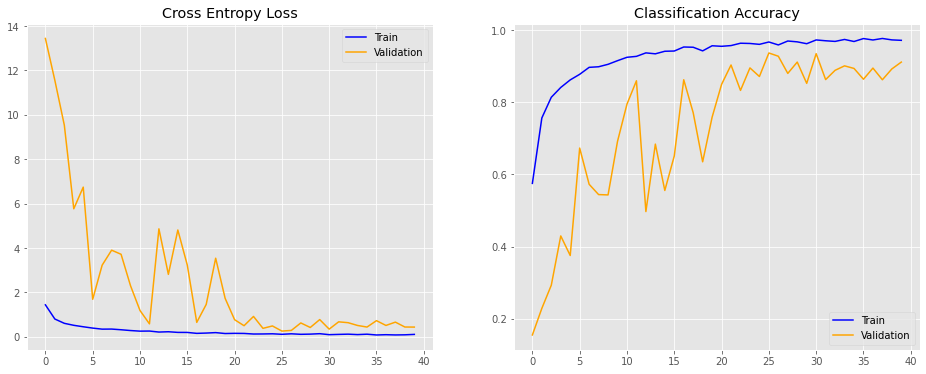

In [ ]:
summarize(history)

### Validation and Confusion Matrix

In [ ]:
def show_conf_matrix(conf_mtx, classes, cmap=plt.cm.Blues):
    
    conf_mtx = conf_mtx.astype('float')/conf_mtx.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(20,20))
    plt.imshow(conf_mtx, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    marks = np.arange(len(classes))
    plt.xticks(marks, classes,rotation=90)
    plt.yticks(marks, classes)
    
    fmrt = '.2f'
    limit = conf_mtx.max()/2.0   
    for i,j in itertools.product(range(conf_mtx.shape[0]), range(conf_mtx.shape[1])):
        plt.text(j,i, format(conf_mtx[i,j], fmrt),
                horizontalalignment = "center",
                color = "white" if conf_mtx[i,j] > limit else "black")
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(None);

In [ ]:
val_predict = model.predict(val_imgs)
val_predict = np.argmax(val_predict, axis=1)
val_predict.shape

(2100,)

<Figure size 432x288 with 0 Axes>

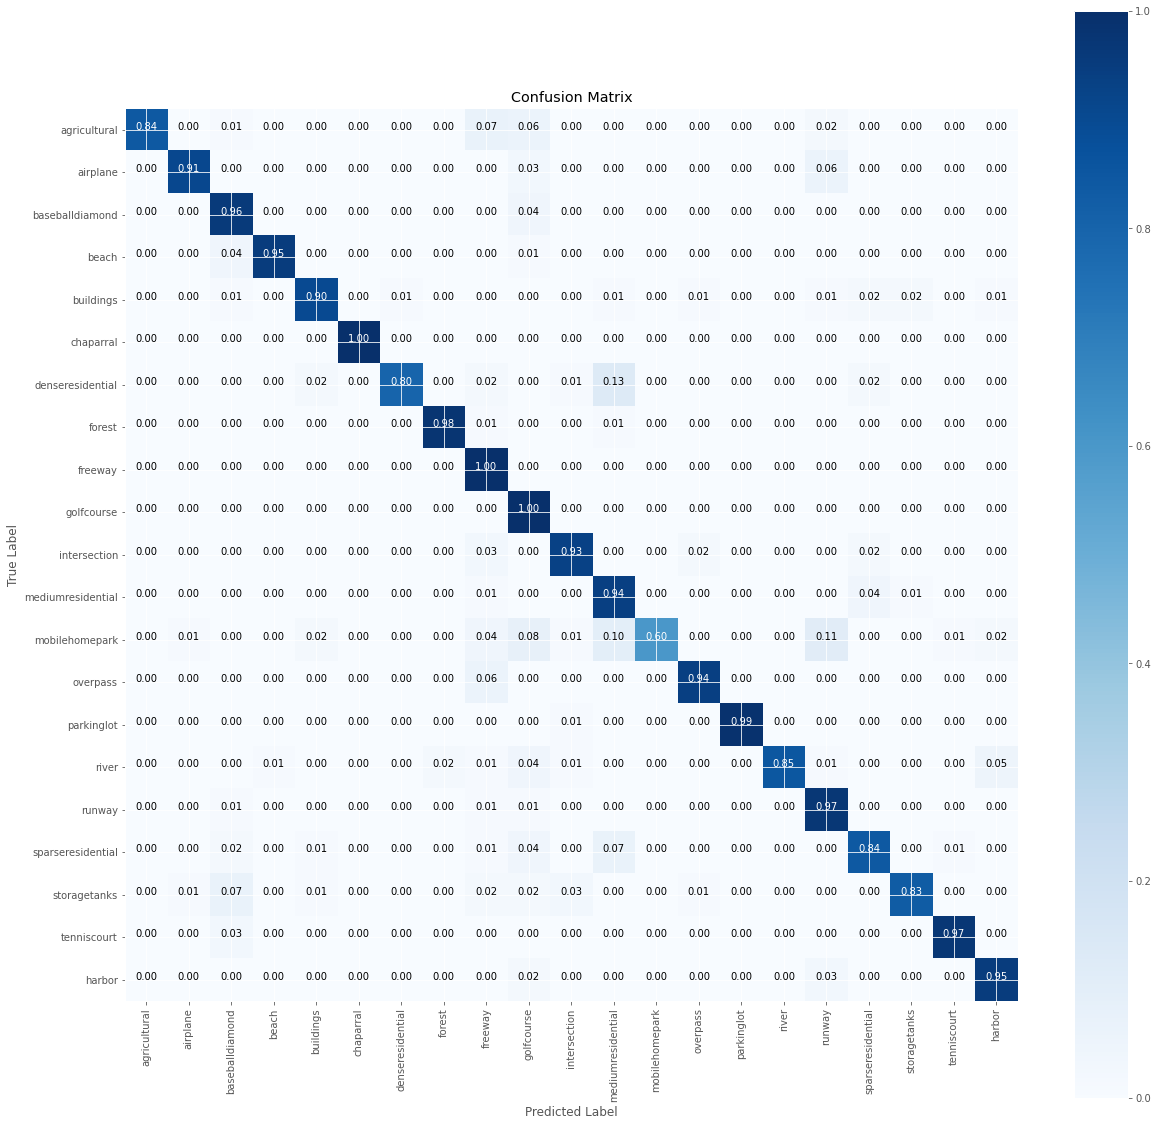

In [ ]:
val_actual = np.argmax(val_classes, axis=1)

conf_matrix = confusion_matrix(val_actual, val_predict)
np.set_printoptions(precision=2)

plt.figure()
show_conf_matrix(conf_matrix, classes=out_classes)
plt.grid(None)
plt.show()

### Make Predictions

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
#Formula
# accuracy: (tp + tn) / (p + n)
MobileNetV2_Accuracy = accuracy_score(val_actual, val_predict)
print('MobileNetV2 - Validation Accuracy: %f' % MobileNetV2_Accuracy)

#Formula
# precision tp / (tp + fp)
MobileNetV2_precision = precision_score(val_actual, val_predict, average="weighted")
print('MobileNetV2 - Precision : %f' % MobileNetV2_precision)

#Formula
# recall: tp / (tp + fn)
MobileNetV2_recall = recall_score(val_actual, val_predict, average="weighted")
print('MobileNetV2 - Recall : %f' % MobileNetV2_recall)

#Formula
# f1: 2 tp / (2 tp + fp + fn)
MobileNetV2_f1_sc = f1_score(val_actual, val_predict, average="weighted")
print('MobileNetV2 - F1 score : %f' % MobileNetV2_f1_sc)

MobileNetV2 - Validation Accuracy: 0.911905
MobileNetV2 - Precision : 0.924842
MobileNetV2 - Recall : 0.911905
MobileNetV2 - F1 score : 0.911790


In [ ]:
_, model_base_acc = model.evaluate(
   test_imgs, test_classes, verbose=0)

print('Test accuracy for base:', model_base_acc) 

Test accuracy for base: 0.9266666769981384


### Save the model

In [ ]:
# model.save("/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/Pruned Model/MobileNetV2/MobileNetV2_New_baseline.h5")

In [ ]:
MobileNetV2_base_fin = load_model('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/Pruned Model/MobileNetV2/MobileNetV2_New_baseline.h5')

### Calculate Inference time

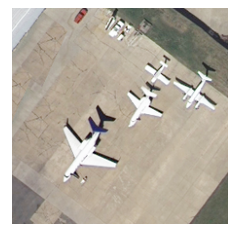

Predicted Class is: 1
Inference time is:  0.05246192900085589


In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import time 

# read and reshape the image
def prep_image(image):
    image = load_img(image, target_size=(224, 224))
    # Show image
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.show()
    # Read into an array
    image = img_to_array(image)
    image = image.reshape(1, 224, 224, 3)
    image = image.astype('float32')
    image = image / 255.0
    return image
 
# Read Image
pred_img = prep_image('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/airplane00_r.tif')

# predict the class
start = time.perf_counter()
pre_class = MobileNetV2_base_fin.predict(pred_img)
pre_class=np.argmax(pre_class,axis=1)
end = time.perf_counter()

ir_time = end-start
print("Predicted Class is:", pre_class[0])
print("Inference time is: ", ir_time)

# Model Pruning 

In [ ]:
!pip install tensorflow_model_optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 238 kB 14.4 MB/s 


In [ ]:
import tensorflow_model_optimization as tfmot
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
# Compute end step to finish pruning after 2 epochs.
batch_size = 10
epochs = 30

end_step = np.ceil(train_imgs.shape[0]//batch_size).astype(np.int32) * epochs

# Model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# compile the pruned model
model_for_pruning.compile(optimizer='adam',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 prune_low_magnitude_Conv1 (Pru  (None, 112, 112, 32  1730       ['input_1[0][0]']                
 neLowMagnitude)                )                                                                 
                                                                                                  
 prune_low_magnitude_bn_Conv1 (  (None, 112, 112, 32  129        ['prune_low_magnitude_Conv1[0][0]
 PruneLowMagnitude)             )                                ']                           

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit(train_imgs, train_classes,
                      steps_per_epoch=len(train_imgs)//10,
                      epochs=40, 
                      verbose=1,
                      validation_data=(val_imgs,val_classes),
                      validation_steps=len(val_imgs)//10)
                      # callbacks=callbacks)

Epoch 1/40
735/735 [==============================] - 59s 79ms/step - loss: 0.0743 - accuracy: 0.9823 - val_loss: 1.6362 - val_accuracy: 0.6852
Epoch 2/40
735/735 [==============================] - 56s 76ms/step - loss: 0.0584 - accuracy: 0.9844 - val_loss: 1.0680 - val_accuracy: 0.7976
Epoch 3/40
735/735 [==============================] - 56s 76ms/step - loss: 0.0573 - accuracy: 0.9812 - val_loss: 0.7325 - val_accuracy: 0.8543
Epoch 4/40
735/735 [==============================] - 55s 75ms/step - loss: 0.0381 - accuracy: 0.9894 - val_loss: 2.0664 - val_accuracy: 0.6986
Epoch 5/40
735/735 [==============================] - 56s 76ms/step - loss: 0.0494 - accuracy: 0.9852 - val_loss: 0.9372 - val_accuracy: 0.8110
Epoch 6/40
735/735 [==============================] - 56s 76ms/step - loss: 0.0570 - accuracy: 0.9849 - val_loss: 0.3982 - val_accuracy: 0.9043
Epoch 7/40
735/735 [==============================] - 55s 75ms/step - loss: 0.0471 - accuracy: 0.9859 - val_loss: 0.2663 - val_accuracy:

In [ ]:
_, model_prun_acc = model_for_pruning.evaluate(
   test_imgs, test_classes, verbose=0)

print('Test accuracy for base model:', model_base_acc) 
print('Test accuracy for Prunned model:', model_prun_acc)

Test accuracy for base model: 0.9266666769981384
Test accuracy for Prunned model: 0.9666666388511658


In [ ]:
#model_for_pruning.save('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/Pruned Model/MobileNetV2/model_for_pruning.h5')

In [ ]:
#model_for_pruning = load_model('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/Pruned Model/MobileNetV2/model_for_pruning.h5')

In [ ]:
val_pred_prun = model_for_pruning.predict(val_imgs)
val_pred_prun = np.argmax(val_pred_prun, axis=1)
val_pred_prun.shape

(2100,)

<Figure size 432x288 with 0 Axes>

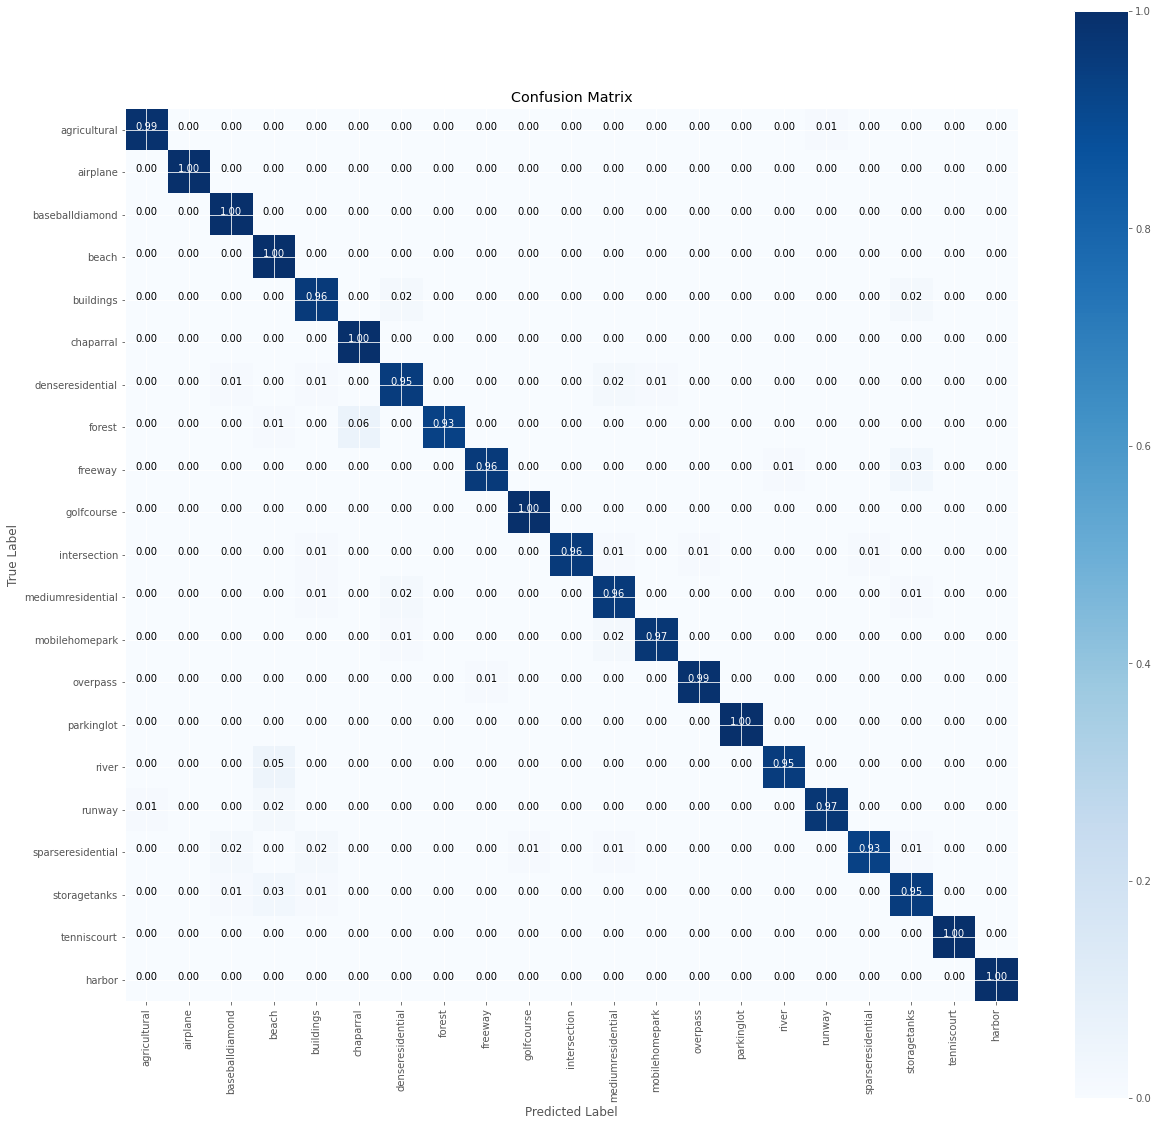

In [ ]:
val_actual = np.argmax(val_classes, axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred_prun)
np.set_printoptions(precision=2)

plt.figure()
show_conf_matrix(cnf_mat, classes=out_classes)
plt.grid(None)
plt.show();

### Model Prediction Accuracy

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
#Formula
# accuracy: (tp + tn) / (p + n)
MobileNetV2_Accuracy_prun = accuracy_score(val_actual, val_pred_prun)
print('Pruning MobileNetV2 - Validation Accuracy: %f' % MobileNetV2_Accuracy_prun)

#Formula
# precision tp / (tp + fp)
MobileNetV2_precision_prun = precision_score(val_actual, val_pred_prun, average="weighted")
print('Pruning MobileNetV2 - Precision : %f' % MobileNetV2_precision_prun)

#Formula
# recall: tp / (tp + fn)
MobileNetV2_recall_prun = recall_score(val_actual, val_pred_prun, average="weighted")
print('Pruning MobileNetV2 - Recall : %f' % MobileNetV2_recall_prun)

#Formula
# f1: 2 tp / (2 tp + fp + fn)
MobileNetV2_f1_sc_prun = f1_score(val_actual, val_pred_prun, average="weighted")
print('Pruning MobileNetV2 - F1 score : %f' % MobileNetV2_f1_sc_prun)

Pruning MobileNetV2 - Validation Accuracy: 0.974762
Pruning MobileNetV2 - Precision : 0.975614
Pruning MobileNetV2 - Recall : 0.974762
Pruning MobileNetV2 - F1 score : 0.974830


### Inference on Pruned Model

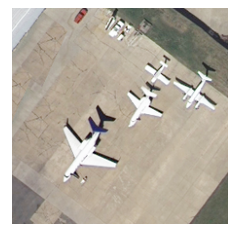

Predicted Class is: 1
Inference time is:  0.05334032000064326


In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import time 

# read and reshape the image
def prep_image(image):
    image = load_img(image, target_size=(224, 224))
    # Show image
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.show()
    # Read into an array
    image = img_to_array(image)
    image = image.reshape(1, 224, 224, 3)
    image = image.astype('float32')
    image = image / 255.0
    return image
 
# Read Image
pred_img = prep_image('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/airplane00_r.tif')

# predict the class
start = time.perf_counter()
pre_class = model_for_pruning.predict(pred_img)
pre_class=np.argmax(pre_class,axis=1)
end = time.perf_counter()

ir_time = end-start
print("Predicted Class is:", pre_class[0])
print("Inference time is: ", ir_time)

### Grad-CAM Visual on Baseline Model

In [ ]:
def grad_cam_heatmap(pred_img, model, lst_conv_layer, pred_index=None):
    #Created a model which maps the input image to activations of last conv layer and output predictions
    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(lst_conv_layer).output, model.output]
    )

    #Calculate gradient of top predicted class for input image for last conv layer activation
    with tf.GradientTape() as tape:
        lst_conv_layer_out, preds = gradient_model(pred_img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channels = preds[:, pred_index]

    # Gradient of top predicted for output feature map of last conv layer
    grads = tape.gradient(class_channels, lst_conv_layer_out)

    # A vector of mean intensity of the gradient over feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multipled each channel in the feature map array to check importance of channel 
    # with respect to top predicted class and sum of all channel to get heatmap of class activation
    lst_conv_layer_out = lst_conv_layer_out[0]
    heatmap = lst_conv_layer_out @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    #Normalize a heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def grad_cam_display(org_img_path, heatmap, grad_cam_path="grad_cam.jpg", alpha=0.4):
    # Load an image
    img = tf.keras.preprocessing.image.load_img(org_img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to 0-255 range
    heatmap = np.uint8(255 * heatmap)

    # color heatmap using jet colourmap
    jet = cm.get_cmap("jet")

    # Use RGB colormap values
    jet_colors = jet(np.arange(256))[:, :3]
    jet_color_heatmap = jet_colors[heatmap]

    # Created an image with RGB colored heatmap
    jet_color_heatmap = tf.keras.preprocessing.image.array_to_img(jet_color_heatmap)
    jet_color_heatmap = jet_color_heatmap.resize((img.shape[1], img.shape[0]))
    jet_color_heatmap = tf.keras.preprocessing.image.img_to_array(jet_color_heatmap)

    # Superimpose a heatmap on actual image
    superimposed_img = jet_color_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(grad_cam_path)

    # Display Grad CAM
    # display(Image(grad_cam_path))
    
    return grad_cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

lst_conv_layer = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
MobileNetV2_base_fin.layers[-1].activation = None

### Visualise image

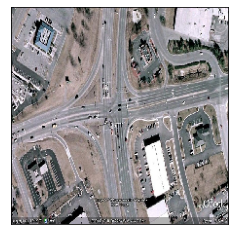

Predicted Class is: 10


Grad-CAM Visual
Predicted Class is: 10


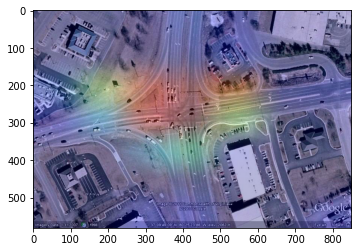

In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import time 
import matplotlib.cm as cm

# read and reshape the image
def prep_image(image):
    image = load_img(image, target_size=(224, 224))
    # Show image
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.show()
    # Read into an array
    image = img_to_array(image)
    image = image.reshape(1, 224, 224, 3)
    image = image.astype('float32')
    image = image / 255.0
    return image
 
# Read Image
pred_img = prep_image('/content/gdrive/My Drive/Colab Notebooks/intersection.png')

# predict the class
start = time.perf_counter()
pre_class = MobileNetV2_base_fin.predict(pred_img)
pre_class=np.argmax(pre_class,axis=1)
end = time.perf_counter()

ir_time = end-start
print("Predicted Class is:", pre_class[0])
# print("Inference time is: ", ir_time)

img_path = '/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model'

# Calculate Grad-CAM class activation
gc_heatmap = grad_cam_heatmap(pred_img, MobileNetV2_base_fin, lst_conv_layer)
# print(heatmap)
g_cam_path = grad_cam_display('/content/gdrive/My Drive/Colab Notebooks/intersection.png', gc_heatmap)
img = plt.imread(g_cam_path)
img = plt.imshow(img)

print("\n\nGrad-CAM Visual")
print("Predicted Class is:", pre_class[0])

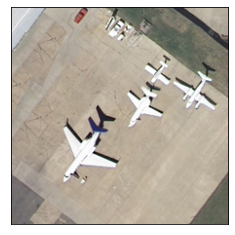

Predicted Class is: 1


Grad-CAM Visual
Predicted Class is: 1


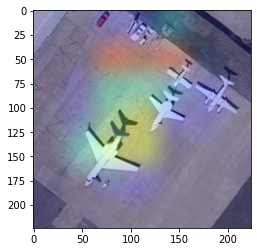

In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import time 
import matplotlib.cm as cm

# read and reshape the image
def prep_image(image):
    image = load_img(image, target_size=(224, 224))
    # Show image
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.show()
    # Read into an array
    image = img_to_array(image)
    image = image.reshape(1, 224, 224, 3)
    image = image.astype('float32')
    image = image / 255.0
    return image
 
# Read Image
pred_img = prep_image('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/airplane00_r.tif')

# predict the class
start = time.perf_counter()
pre_class = MobileNetV2_base_fin.predict(pred_img)
pre_class=np.argmax(pre_class,axis=1)
end = time.perf_counter()

ir_time = end-start
print("Predicted Class is:", pre_class[0])
# print("Inference time is: ", ir_time)

img_path = '/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model'

# Calculate Grad-CAM class activation
gc_heatmap = grad_cam_heatmap(pred_img, MobileNetV2_base_fin, lst_conv_layer)
# print(heatmap)
g_cam_path = grad_cam_display('/content/gdrive/My Drive/Colab Notebooks/Final Model/Pruning Model/Formatted_Pruning_Model/airplane00_r.tif', gc_heatmap)
img = plt.imread(g_cam_path)
img = plt.imshow(img)

print("\n\nGrad-CAM Visual")
print("Predicted Class is:", pre_class[0])